# Lab1 Feature extraction 2020.3.22
# Yuxia Wang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,fftpack
from scipy.fftpack.realtransforms import dct
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture


In [2]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

In [4]:
example

{'samples': array([ 2,  2, -1, ..., -3, -7, -3], dtype=int16),
 'samplingrate': 20000,
 'frames': array([[  2.,   2.,  -1., ...,  -6.,  -6.,  -3.],
        [  3.,   4.,   5., ...,   0.,  -1.,   1.],
        [ -4.,   0.,  -1., ...,   0.,   0.,   1.],
        ...,
        [ 26.,  26.,  27., ...,  17.,  15.,  17.],
        [ -6.,  -7.,  -6., ...,   0.,   3.,   2.],
        [ 16.,  16.,  16., ...,  -9.,  -7., -10.]]),
 'preemph': array([[ 2.  ,  0.06, -2.94, ..., -0.18, -0.18,  2.82],
        [ 3.  ,  1.09,  1.12, ...,  0.  , -1.  ,  1.97],
        [-4.  ,  3.88, -1.  , ..., -0.97,  0.  ,  1.  ],
        ...,
        [26.  ,  0.78,  1.78, ...,  2.45, -1.49,  2.45],
        [-6.  , -1.18,  0.79, ..., -0.97,  3.  , -0.91],
        [16.  ,  0.48,  0.48, ..., -1.24,  1.73, -3.21]]),
 'windowed': array([[ 0.16      ,  0.0048034 , -0.23586733, ..., -0.01449192,
         -0.01444086,  0.22576003],
        [ 0.24      ,  0.08726186,  0.08985422, ...,  0.        ,
         -0.08022698,  0.1577118 ]

Text(0.5, 1.0, 'Samples')

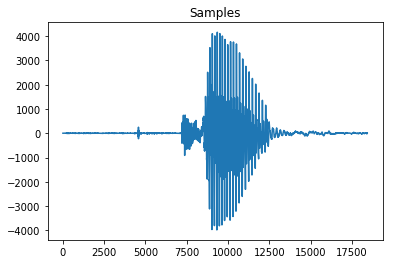

In [5]:
plt.plot(example['samples'])
plt.title('Samples')

In [6]:
example['samples'].shape

(18432,)

Text(0.5, 1.0, 'Frames')

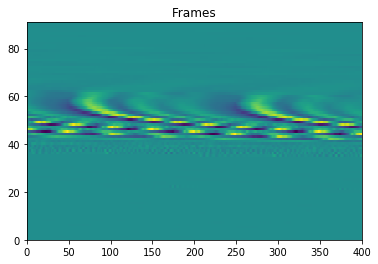

In [7]:
plt.pcolormesh(example['frames'])
plt.title('Frames')

In [8]:
example['frames'].shape

(91, 400)

Text(0.5, 1.0, 'Preemphasis')

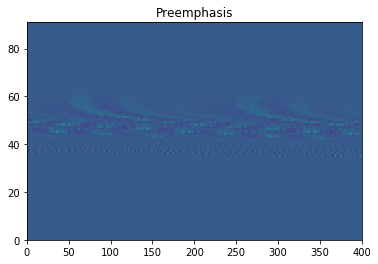

In [9]:
plt.pcolormesh(example['preemph'])
plt.title('Preemphasis')

Text(0.5, 1.0, 'Windowed')

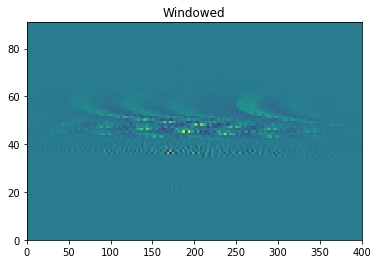

In [10]:
plt.pcolormesh(example['windowed'])
plt.title('Windowed')

Text(0.5, 1.0, 'Spec after FFT')

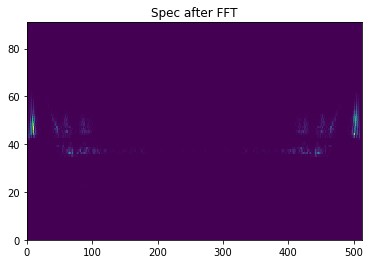

In [11]:
plt.pcolormesh(example['spec'])
plt.title('Spec after FFT')

Text(0.5, 1.0, 'Mspec')

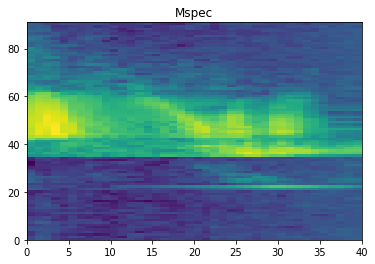

In [12]:
plt.pcolormesh(example['mspec'])
plt.title('Mspec')

Text(0.5, 1.0, 'MFCC')

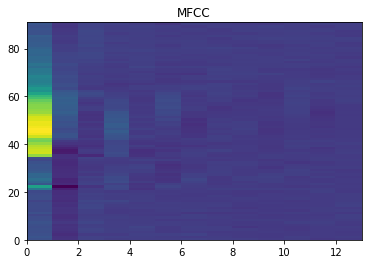

In [13]:
plt.pcolormesh(example['mfcc'])
plt.title('MFCC')

Text(0.5, 1.0, 'LMFCC')

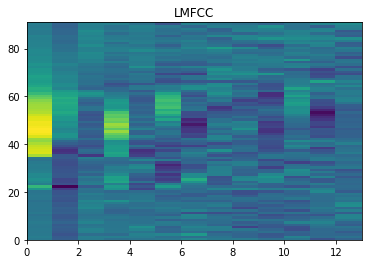

In [14]:
plt.pcolormesh(example['lmfcc'])
plt.title('LMFCC')

# Function tools from teacher

In [15]:
def tidigit2labels(tidigitsarray):
    """
    Return a list of labels including gender, speaker, digit and repetition information for each
    utterance in tidigitsarray. Useful for plots.
    """
    labels = []
    nex = len(tidigitsarray)
    for ex in range(nex):
        labels.append(tidigitsarray[ex]['gender'] + '_' + 
                      tidigitsarray[ex]['speaker'] + '_' + 
                      tidigitsarray[ex]['digit'] + '_' + 
                      tidigitsarray[ex]['repetition'])
    return labels

def dither(samples, level=1.0):
    """
    Applies dithering to the samples. Adds Gaussian noise to the samples to avoid numerical
        errors in the subsequent FFT calculations.

        samples: array of speech samples
        level: decides the amount of dithering (see code for details)

    Returns:
        array of dithered samples (same shape as samples)
    """
    return samples + level*np.random.normal(0,1, samples.shape)
    

def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

def hz2mel(f):
    """Convert an array of frequency in Hz into mel."""
    return 1127.01048 * np.log(f/700 +1)

def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.

    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters

    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank



# Question- 4

In [33]:
def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, 
         liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

# Functions to be implemented ----------------------------------

def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    frame = np.array(samples[0:winlen].reshape((1, winlen)))
    stepsize = winlen - winshift
    for i in range(stepsize, len(samples) - winlen, stepsize):
        frame = np.vstack((frame, samples[i:i+winlen].reshape((1, winlen))))
    return frame
    
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    a = [1]
    b = [1, -p]
    return signal.lfilter(b, a, input, zi=None)

def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windowed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    window = signal.hamming(input.shape[1], sym=False)
   # plt.plot(window)
   # plt.title('Hamming window')
   # plt.show()
    output = []
    for frame in input:
        output.append(frame * window)
    return output

def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    spec = []
    for frame in input:
        spec.append(np.square(np.abs(fftpack.fft(frame, nfft))))
    return spec
    #return np.power(np.abs(fftpack.fft(input, nfft)), 2)

def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    nfft = np.array(input).shape[1]
    mel = trfbank(samplingrate, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, 
                  nlogfilt=27, equalareas=False)
    output = np.dot(input, mel.T)
    output = np.where(output == 0.0, np.finfo(float).eps, output) 
    return np.log(output)

def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    return dct(input, type=2, axis=1, norm = 'ortho')[:,: nceps]

def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """

    N = x.shape[0]
    M = y.shape[0]
    global_dist = 0
    LD = np.zeros((N, M))
    AD = np.zeros((N, M)) 
    path_mat = []

    for i in range(N):
        for j in range(M):
            LD[i, j] = dist(x[i], y[j])
    
    nrows, ncols = AD.shape
    # SET column 0
    for row in range(1,nrows):
        AD[row,0] = AD[row-1,0] + LD[row,0]
    # SET row 0
    for col in range(1,ncols):
        AD[0,col] = AD[0,col-1] + LD[0,col]

    for row in range(1, nrows): # Start from 1 to avoid out of bounds
        for col in range(1, ncols):
            minimum_dist = LD[row, col] + min(AD[row, col-1], AD[row-1, col], AD[row-1, col-1]) 
            AD[row, col] = minimum_dist
  
    backtracking = True
    i, j = nrows-1, ncols-1
    path_mat.append((i,j))
    while backtracking:
        min_dist =  min(AD[i, j-1],
                        AD[i-1, j],
                        AD[i-1, j-1])
        min_idx = np.where(AD==min_dist)
        i, j = min_idx[0][0], min_idx[1][0]
        path_mat.append((i,j))
        if i == 0 and j == 0:
            backtracking = False

    global_dist = AD[nrows-1,ncols-1] / (N + M)
        
    return global_dist, LD, AD, path_mat

def Euclidean(x,y):
    return np.linalg.norm(x-y)

def backtrack(AD):
    """
    Returns best path through accumulated distance matrix AD
    """
    N = AD.shape[0]
    M = AD.shape[1]
    path = [(N - 1, M - 1)]
    i = N - 1
    j = M - 1
    while(i > 0 or j > 0):
        if( i > 0 and j > 0):
            argmin = np.argmin([AD[i - 1, j - 1], AD[i - 1, j], AD[i, j - 1]])
            if(argmin == 0):
                path.append((i - 1, j - 1))
                i = i - 1
                j = j - 1
            elif(argmin == 1):
                path.append((i - 1, j))
                i = i - 1
            elif(argmin == 2):
                path.append((i, j - 1))
                j = j - 1
        elif(i == 0 and j > 0):
            path.append((0, j - 1))
            j = j - 1
        else:
            path.append((i - 1, 0))
            i = i - 1
    return path


# Testing functions above

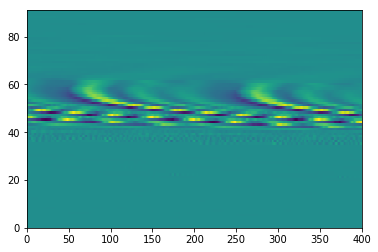

In [17]:
f = enframe(example['samples'], 400, 200)
plt.pcolormesh(f)

In [18]:
f.shape

(91, 400)

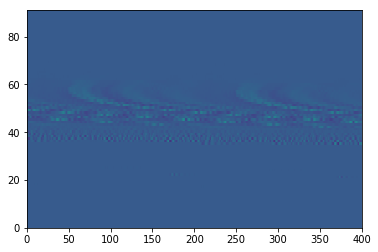

In [19]:
preemp_f = preemp(f, p=0.97)
plt.pcolormesh(preemp_f)

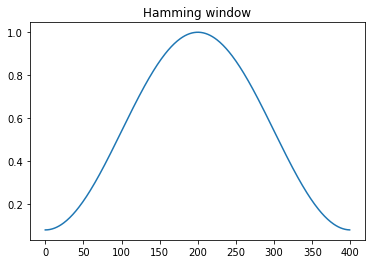

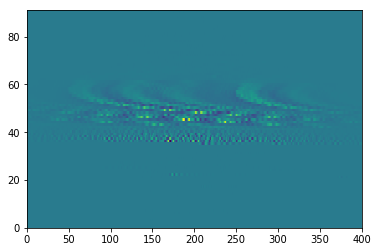

In [34]:
windowed = windowing(preemp_f)
plt.pcolormesh(windowed)

In [25]:
np.array(windowed).shape

(91, 400)

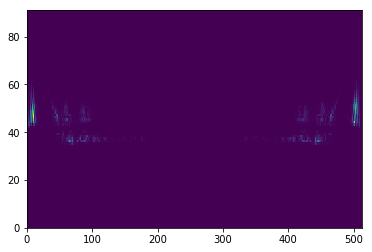

In [177]:
spec = powerSpectrum(windowed, 512)
plt.pcolormesh(spec)

In [178]:
trfilter = trfbank(20000, 512)
trfilter.shape

(40, 512)

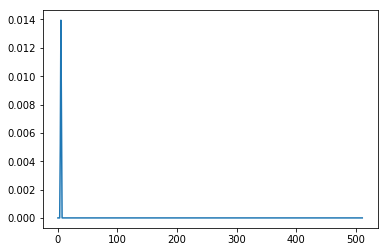

In [179]:
plt.plot(trfilter[0]);


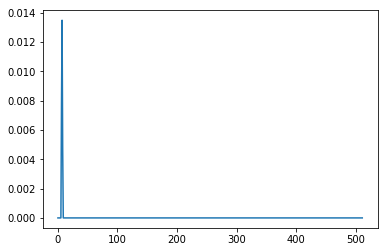

In [180]:
plt.plot(trfilter[1]);

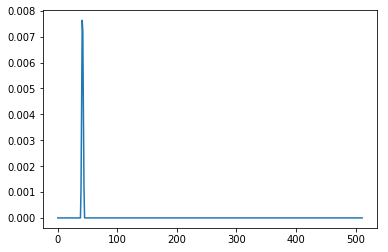

In [181]:
plt.plot(trfilter[19]);

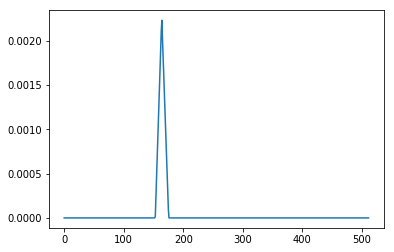

In [182]:
plt.plot(trfilter[39]);

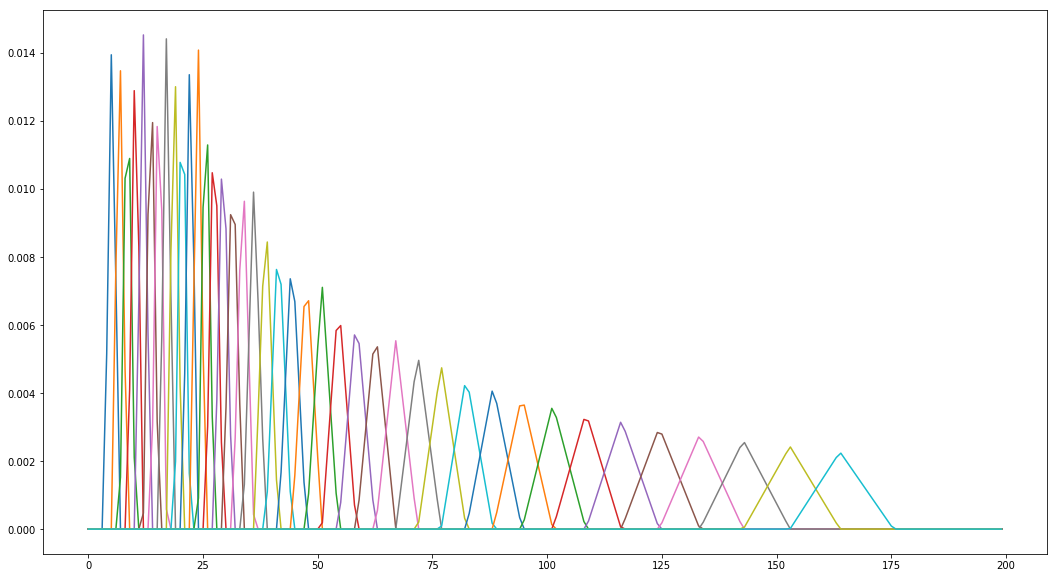

In [186]:
fig = plt.figure(figsize=(18, 10))
plt.plot(trfilter.T[:200]);

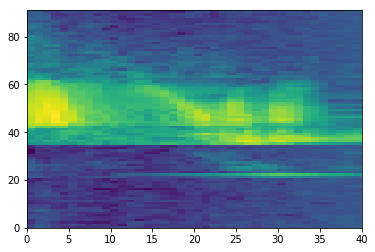

In [27]:
mels = logMelSpectrum(spec, 20000)
plt.pcolormesh(mels)

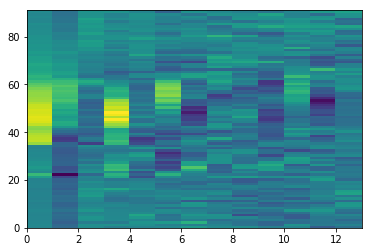

In [28]:
lmfcc = mfcc(example['samples'])
plt.pcolormesh(lmfcc)

# Question- 5,6,7

In [11]:
data = np.load('lab1_data.npz',allow_pickle=True)['data']

In [12]:
data[0]['samples'].shape


(16640,)

In [13]:
data[1]['samples'].shape

(15104,)

In [14]:
def feature_corr(data, lift=False):
    utterances = np.empty((0,13))
    for d in data:
        if not lift:
            utterances = np.empty((0,40))
            frames = enframe(d['samples'], 400, 200)
            preemph = preemp(frames, 0.97)
            windowed = windowing(preemph)
            spec = powerSpectrum(windowed, 512)
            mspec = logMelSpectrum(spec, 20000)
            ceps = cepstrum(mspec, 13)
            utterances = np.concatenate((utterances, mspec),axis=0)
        else:
            utterances = np.concatenate((utterances, mfcc(d['samples'])),axis=0)
    
    print(utterances.shape)
    #print(data[0]['samples'])
    return np.corrcoef(utterances.T)


(79, 40)


Text(0.5, 1.0, 'Correlation for mspec')

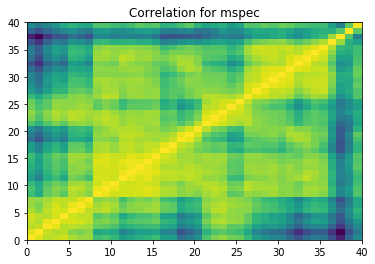

In [23]:
mel = feature_corr(data, lift=False)
plt.pcolormesh(mel)
plt.title('Correlation for mspec')

(3883, 13)


Text(0.5, 1.0, 'Correlation for lmfcc')

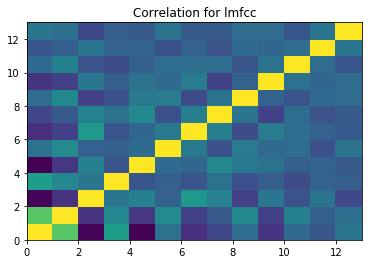

In [24]:
MFCC = feature_corr(data, lift=True)
plt.pcolormesh(MFCC)
plt.title('Correlation for lmfcc')

In [35]:
def feature_extraction(data):
    sampled_signals = []
    signal_features = []
    for d in data:
        sampled_signal = d['samples']
        extracted_features = mfcc(sampled_signal, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, 
                              nceps=13, samplingrate=20000, liftercoeff=22)
        signal_features.append(extracted_features)
   # print(signal_features)

    np.savez("./lmfcc_utterance_features.npz",signal_features)


def get_global_dist(features):
    N = len(features)
    GD = np.zeros((N,N))
    for i in range(N):
        x = features[i]
        for j in range(N):
            y = features[j]
            GD[i,j], _, _, _ = dtw(x,y,Euclidean)
    return GD

In [138]:
feature_extraction(data)

In [36]:
features = np.load('lmfcc_utterance_features.npz',allow_pickle=True)['arr_0']
features.shape

(44,)

In [201]:
features[2].shape

(97, 13)

In [203]:
features[10].shape

(86, 13)

In [39]:
d, LD, AD, path = dtw(features[2], features[10], Euclidean)

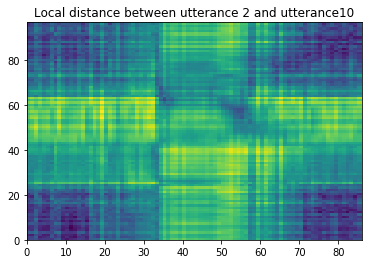

In [40]:
plt.pcolormesh(LD)
plt.title('Local distance between utterance 2 and utterance 10')
plt.show()

Text(0.5, 1.0, 'ACC distance betwwen utterance 2 and utterance 10')

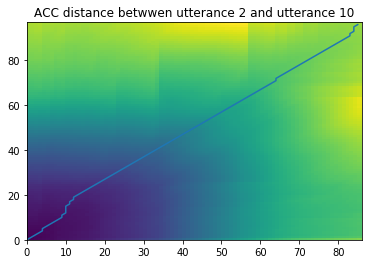

In [38]:
plt.pcolormesh(AD);
path = np.array(path)
plt.plot(path[:,1],path[:,0])
plt.title('ACC distance between utterance 2 and utterance 10')


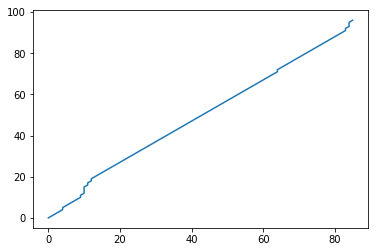

In [199]:
path = np.array(path)
plt.plot(path[:,1],path[:,0])

In [198]:
path

array([[96, 85],
       [95, 84],
       [94, 84],
       [93, 84],
       [92, 83],
       [91, 83],
       [90, 82],
       [89, 81],
       [88, 80],
       [87, 79],
       [86, 78],
       [85, 77],
       [84, 76],
       [83, 75],
       [82, 74],
       [81, 73],
       [80, 72],
       [79, 71],
       [78, 70],
       [77, 69],
       [76, 68],
       [75, 67],
       [74, 66],
       [73, 65],
       [72, 64],
       [71, 64],
       [70, 63],
       [69, 62],
       [68, 61],
       [67, 60],
       [66, 59],
       [65, 58],
       [64, 57],
       [63, 56],
       [62, 55],
       [61, 54],
       [60, 53],
       [59, 52],
       [58, 51],
       [57, 50],
       [56, 49],
       [55, 48],
       [54, 47],
       [53, 46],
       [52, 45],
       [51, 44],
       [50, 43],
       [49, 42],
       [48, 41],
       [47, 40],
       [46, 39],
       [45, 38],
       [44, 37],
       [43, 36],
       [42, 35],
       [41, 34],
       [40, 33],
       [39, 32],
       [38, 31

In [32]:
gd = get_global_dist(features)

Text(0.5, 1.0, 'global distances for all utterances')

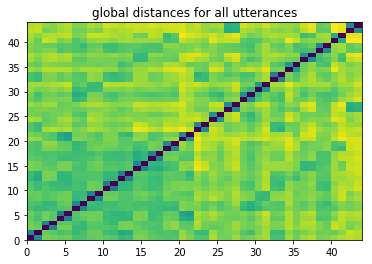

In [34]:
plt.pcolormesh(gd)
plt.title('global distances for all utterances')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


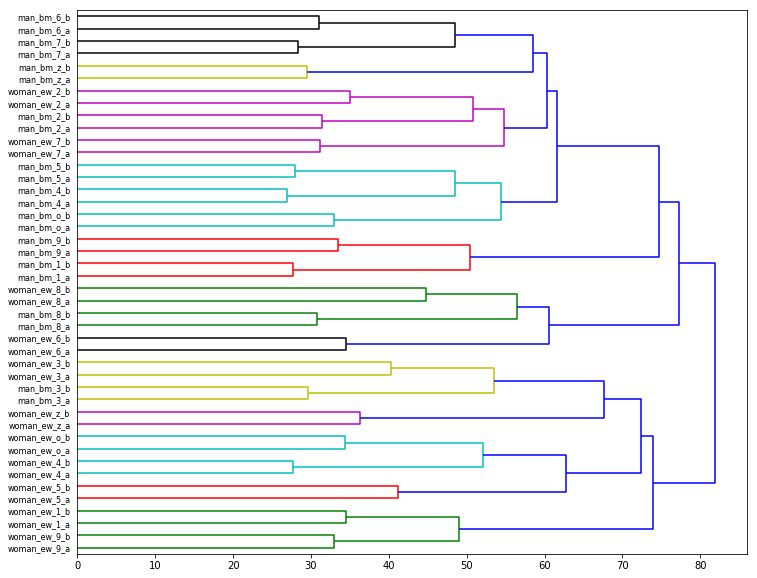

In [170]:
fig = plt.figure(figsize=(12, 10))
labels = tidigit2labels(data)
linkage_matrix = linkage(gd, method = 'complete')
dendrogram(linkage_matrix, labels = labels,orientation = 'right');
plt.savefig('dendrogram.png')

In [17]:
signal_features = np.load('lmfcc_utterance_features.npz',allow_pickle=True)['arr_0']
features = signal_features[0]
for idx, sample_features in enumerate(signal_features):
    if(idx > 0):
        features = np.vstack((features, sample_features))
print(signal_features.shape)

models = []
components = [4,8,16,32]
for c in components:
    # Create model
    gmm = GaussianMixture(c, covariance_type='diag',max_iter=1000, verbose=1)
    # Train on all data
    gmm.fit(features)
    models.append(gmm)


(44,)
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [18]:
features.shape

(3883, 13)

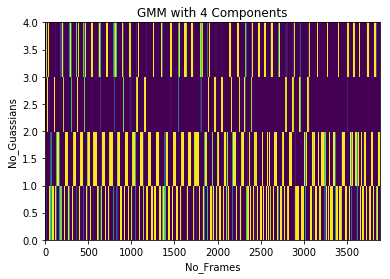

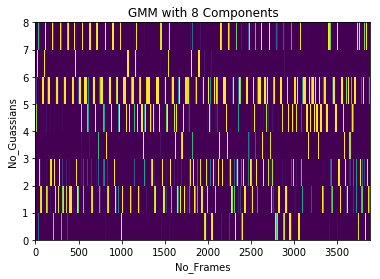

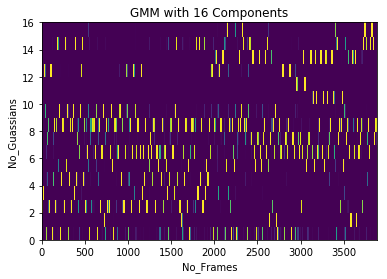

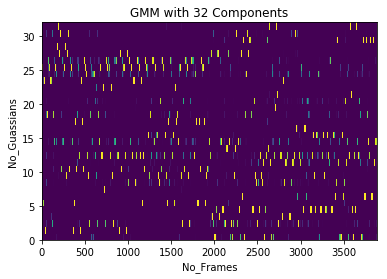

In [66]:
for i in range(4): 
    poster = models[i].predict_proba(features) 
    plt.ylabel('No_Guassians') 
    plt.xlabel('No_Frames') 
    plt.title("GMM with %d Components"%components[i]) 
    plt.pcolormesh(poster.T) 
    plt.show()


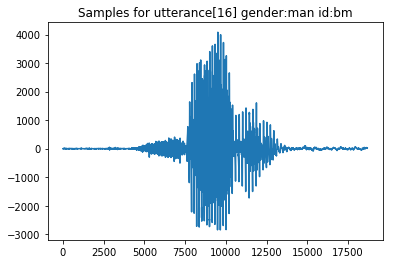

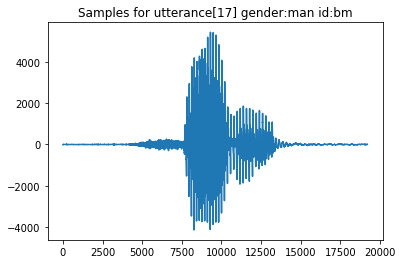

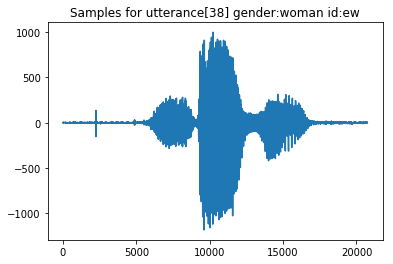

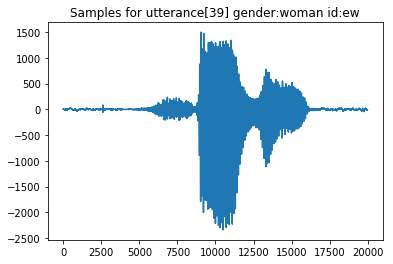

In [15]:
utterances_index = [16, 17, 38, 39]
for i in utterances_index:
    plt.title('Samples for utterance[%d] gender:%s id:%s'%(i,data[i]['gender'],data[i]['speaker']))
    plt.plot(data[i]['samples'])
    plt.show()

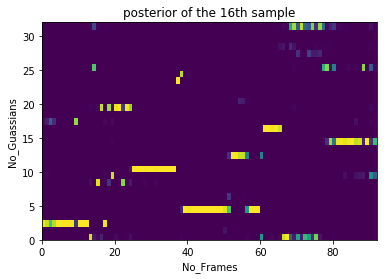

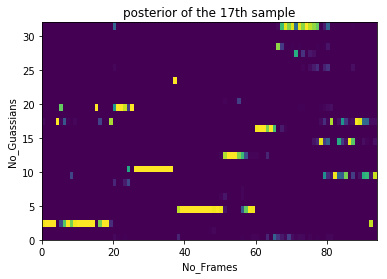

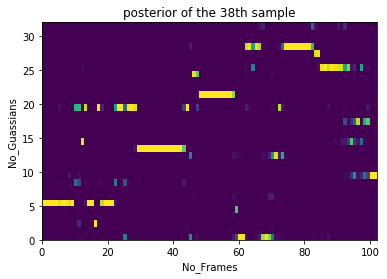

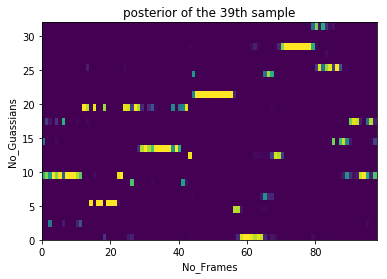

In [22]:
for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster = models[3].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster.T)
    plt.ylabel('No_Guassians') 
    plt.xlabel('No_Frames') 
    plt.show()

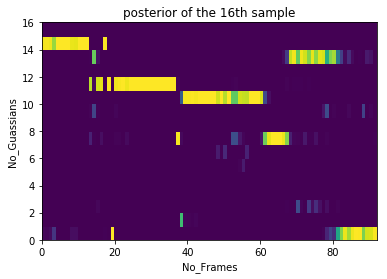

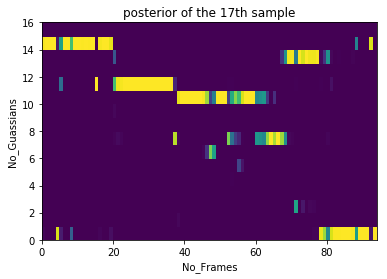

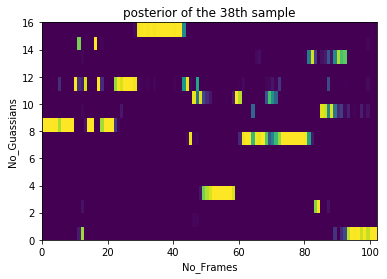

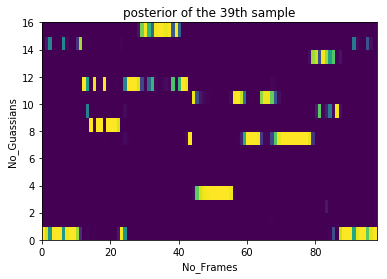

In [23]:
for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster = models[2].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster.T)
    plt.ylabel('No_Guassians') 
    plt.xlabel('No_Frames') 
    plt.show()

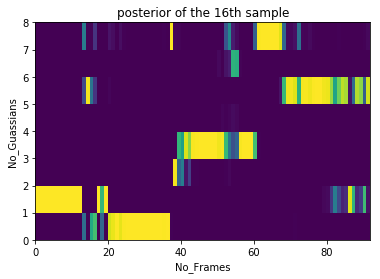

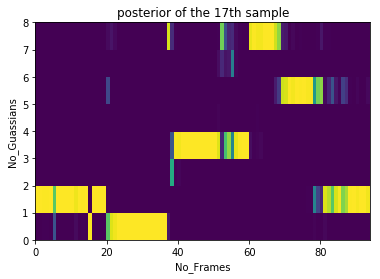

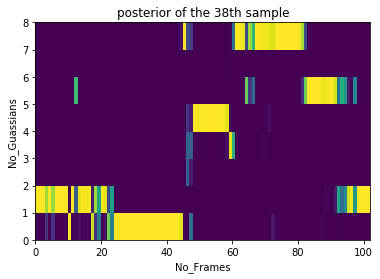

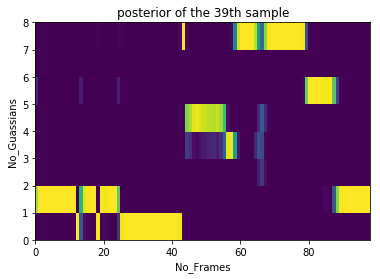

In [24]:
for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster = models[1].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster.T)
    plt.ylabel('No_Guassians') 
    plt.xlabel('No_Frames') 
    plt.show()

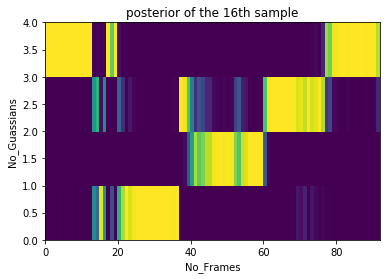

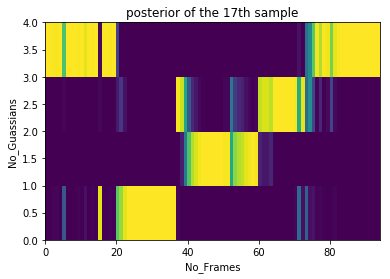

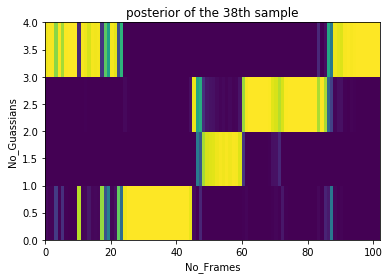

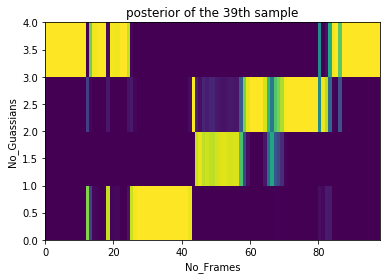

In [25]:
for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster = models[0].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster.T)
    plt.ylabel('No_Guassians') 
    plt.xlabel('No_Frames') 
    plt.show()